# ASL Processing Part 2

In the [previous notebook](./ASLPart1.ipynb), we have seen how to preprocess the data and train a model, the model began to overfit after 10 epochs. In this notebook, we will see how to use data augmentation to improve the model's performance.

We will use the same data set as before, if the data set is not present run the first notebook to download the data set.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import struct
import sys
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import zipfile
import string

# Visualization tools
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import pandas as pd

sys.path.append("../")
import Utils

device = Utils.get_device()

DATASET_LOCATION = ""
if Utils.in_lab():
    DATASET_LOCATION = "/transfer/mnist_asl/"
else:
    DATASET_LOCATION = "./mnist_asl/"

print(f"Dataset location: {DATASET_LOCATION}")
pathlib.Path(DATASET_LOCATION).mkdir(parents=True, exist_ok=True)

Dataset location: ./mnist_asl/


We can load our data set  using pandas as before, however this time we will want to format it into a different shape (28x28 pixels) so we can run image processing on it. This is because most image processing algorithms are designed to work with images, and not flattened arrays.


In [2]:
train_df = pd.read_csv(f"{DATASET_LOCATION}sign_mnist_train.csv")
valid_df = pd.read_csv(f"{DATASET_LOCATION}sign_mnist_test.csv")

## Data processing

To demonstrate the data processing, we will use the first image in the data set as a sample and re-shape it to 28x28 pixels.

In [3]:
sample_df = train_df.head().copy()  # Grab the top 5 rows
sample_df.pop("label")
sample_x = sample_df.values
print(sample_x.shape)

(5, 784)


In this format we don't have pixel proximity locations which convulational neural networks use to learn patterns. We will use the `reshape` function from NumPy to convert the image to 28x28 pixels.


Note that for the first convolution layer of our model, we need to have not only the height and width of the image, but also the number of color channels (1 in our case as greyscale images).

That means that we need to convert the current shape `(5, 784)` to `(5, 1, 28, 28)`. With [NumPy](https://numpy.org/doc/stable/index.html) arrays, we can pass a `-1` for any dimension we wish to remain the same.

Which is 5 image of 1 channel   with 28x28 pixels.

(5, 1, 28, 28)


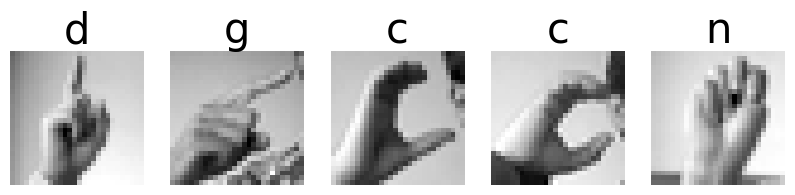

In [4]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
IMAGE_CHANNELS = 1

sample_x = sample_x.reshape(-1, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)
print(sample_x.shape)


def plot_image(images, labels, num_images):
    image = images.reshape(28, 28)
    label = labels
    plt.subplot(1, num_images, i + 1)
    plt.title(label, fontdict={"fontsize": 30})
    plt.axis("off")
    plt.imshow(image, cmap="gray")


plt.figure(figsize=(10, 10))
alphabet = string.ascii_letters[:25]
for i in range(len(sample_x)):
    plot_image(sample_x[i], alphabet[train_df["label"][i]], 5)

## Creating a Dataset

We can create our own data set class using the same method as outlined above, we will now generate the class to do this, and then use the DataLoader class to load the data in batches.

As the data is in a dataframe we can set the df.copy method to copy the data into a new dataframe, this will allow us to manipulate the data without changing the original data.

In [5]:
class ASLImages(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop("label")
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT)
        # send to device for processing
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

We can now build our Dataloaders using the DataLoader class from PyTorch. Remember to set the train data to shuffle so the model does not learn the order of the data. We don't need to do this for the validation data as we are not training on it.

In [6]:
BATCH_SIZE = 32

train_data = ASLImages(train_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = ASLImages(valid_df)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

## Creating a Convolution model

A Convolutional Neural Network (CNN) is a type of deep learning model specifically designed to process and analyze visual data, like images and videos. CNNs are highly effective at tasks like image classification, object detection, and facial recognition because they can learn spatial hierarchies and patterns in visual data.

They are made up of many layers but in general follow this pattern:

1. Convolutional Layers:
	- These layers use filters (small matrices) that slide over the input image to detect patterns or features, such as edges, textures, or shapes.
	- Each filter detects a specific feature in a local region of the image, producing a “feature map” that highlights the presence and position of that feature.

2.	Activation Function (e.g., ReLU):
	- After each convolution, an activation function like ReLU (Rectified Linear Unit) is applied, which introduces non-linearity to help the network learn complex patterns.

3.	Pooling Layers:
	- Pooling layers reduce the spatial size (width and height) of feature maps, which helps lower computation and reduces the risk of overfitting.
	- Max pooling is the most common type of pooling, which selects the highest value in a region, making the feature map smaller while keeping key information.
4.	Fully Connected Layers:
	- Near the end of the CNN, fully connected (FC) layers combine all learned features from previous layers to make a final prediction.
	- These layers “flatten” the output of the final convolutional layers and pass them to a typical neural network layer to classify the image or detect objects.
5.	Output Layer:
	- The final layer generates the prediction, often using a softmax function for classification tasks, which provides probabilities for each class.

The overall structure of our CNN is going to be as follows :

1. input layer
2. convolutional layer
3. Max pooling layer (with ReLU activation)
4. Convolutional layer
5. Dropout layer
6. max pooling layer
7. convolutional layer
8. max pooling layer
9. Flatten to Dense layer
10. Dense layer reduction
11. output. Linear layer

We can build this as follows with our Sequential model:


In [7]:
n_classes = 25
kernel_size = 3
flattened_img_size = 75 * 3 * 3

model = nn.Sequential(
    # First convolution
    nn.Conv2d(IMAGE_CHANNELS, 25, kernel_size, stride=1, padding=1),  # 25 x 28 x 28
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 14 x 14
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 14 x 14
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 7 x 7
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  # 75 x 7 x 7
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 3 x 3
    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, n_classes),
)

## Conv2D

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. 

In this first example

```Python
nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1)
```

25 refers to the number of filters that will be learned. Even though `kernel_size = 3`, PyTorch will assume we want 3 x 3 filters. Stride refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

## Batch Normalization

Batch normalization scales the values in the hidden layers to improve training. It can also help with the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

## MaxPool2D

Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster as it has less data to process as it goes through the network.

## Dropout

As we saw in our last example we had overfitting of our data, Dropout is a technique for preventing overfitting. 
 
It will randomly turn on and off neurons in the network. This will help the network to learn more robust features and not rely on a single neuron to make a decision leading to less overfitting.

## Flatten

This layer will take the output of the last convolutional layer and flatten it into a 1D tensor. This will allow us to pass it to a fully connected layer. The output is called a feature vector and will be connected to the final classification layer.

## Linear

This is our final classification layer. It will take the feature vector and output a prediction for each class. We will use the softmax activation function to convert the output to a probability.

We have seen dense linear layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## The final model

We can print out the different layers of the model t
o see the structure of the model.

In [8]:
if device == "cuda":
    model = torch.compile(model.to(device))
model.to(device)

Sequential(
  (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=675, out_features=512, bias=True)
  (15): Dropout(p=0.3, inplace=False)
  (16): ReLU()
  (17): Linear(in_features

You will notice as we traverse the next layers the size of the image is reduced, this is due to the max pooling layers reducing the size of the image. It is important that the size of the input and the prevous layer output match, otherwise the model will not work.

## Training the model

Whilst the model is very different the overall processes we are going to use for everything else are the same as before. 

First we need to define the loss and optimazation functions. 

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

In [10]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N


#  we are going to store the accuracy and loss for each epoch
train_accuracy = []
train_loss = []


def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    train_accuracy.append(accuracy)
    train_loss.append(loss)
    print("Train - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

In [11]:
valid_accuracy = []
valid_loss = []


def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    valid_accuracy.append(accuracy)
    valid_loss.append(loss)
    print("Valid - Loss: {:.4f} Accuracy: {:.4f}".format(loss, accuracy))

Epoch: 0
Train - Loss: 269.9085 Accuracy: 0.9077
Valid - Loss: 30.1503 Accuracy: 0.9525
Epoch: 1
Train - Loss: 15.9709 Accuracy: 0.9957
Valid - Loss: 27.7739 Accuracy: 0.9537
Epoch: 2
Train - Loss: 12.8041 Accuracy: 0.9956
Valid - Loss: 28.4733 Accuracy: 0.9579
Epoch: 3
Train - Loss: 15.1410 Accuracy: 0.9953
Valid - Loss: 69.4296 Accuracy: 0.9081
Epoch: 4
Train - Loss: 12.8561 Accuracy: 0.9960
Valid - Loss: 42.3177 Accuracy: 0.9488
Epoch: 5
Train - Loss: 3.2577 Accuracy: 0.9990
Valid - Loss: 29.7216 Accuracy: 0.9611
Epoch: 6
Train - Loss: 7.0568 Accuracy: 0.9970
Valid - Loss: 13.0904 Accuracy: 0.9782
Epoch: 7
Train - Loss: 6.7256 Accuracy: 0.9976
Valid - Loss: 7.0629 Accuracy: 0.9869
Epoch: 8
Train - Loss: 0.2335 Accuracy: 1.0000
Valid - Loss: 15.8116 Accuracy: 0.9764
Epoch: 9
Train - Loss: 10.5122 Accuracy: 0.9962
Valid - Loss: 42.6383 Accuracy: 0.9402


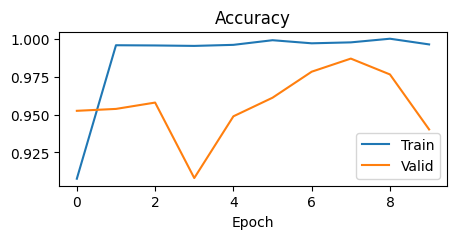

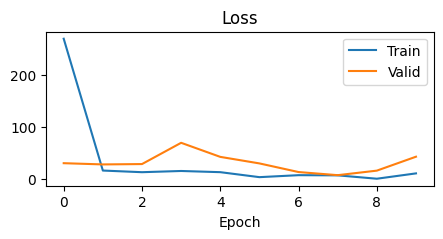

In [12]:
epochs = 10

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    train()
    validate()

# Lets plot the data
plt.figure(figsize=(5, 2))
plt.plot(train_accuracy, label="Train")
plt.plot(valid_accuracy, label="Valid")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(train_loss, label="Train")
plt.plot(valid_loss, label="Valid")
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()
plt.show()

You will notice that this is much improved from before, however there are some jumps in the validation accuracy. Let's see how well it performs on the test data.

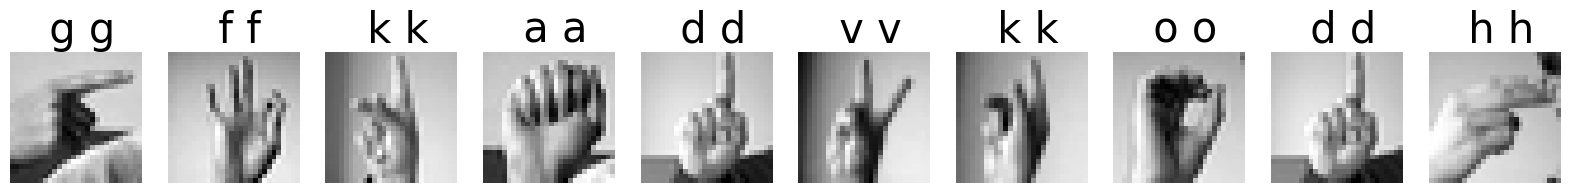

In [13]:
model.eval()
with torch.no_grad():
    # Get a batch of validation data
    # plot the image and the label
    x, y = next(iter(valid_loader))
    output = model(x)
    pred = output.argmax(dim=1, keepdim=True)
    num_images = 10

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.title(f" {alphabet[y[i].item()]} {alphabet[pred[i].item()]}", fontdict={"fontsize": 30})
        plt.axis("off")
        plt.imshow(x[i].cpu().numpy().reshape(28, 28), cmap="gray")

![]({DATASET_LOCATION}/mnist_asl/american_sign_language.PNG)


As you can see from visual inspection it is close but not 100% accurate.  We will improve on this model in the next notebook.


In [14]:
# Lets check the whole data set and see how well we did

model.eval()
with torch.no_grad():
    # loop through all of the test data and see if the prediction is correct
    correct = 0
    total = 0
    for x, y in train_loader:
        output = model(x)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()
        total += y.size(0)
print(f"Accuracy: {correct / total}")

Accuracy: 0.99216900382444
